In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

In [2]:
data_dir = "data/"
model_dir = "../lcls_cu_injector_nn_model/"

## Load Calibration Data

In [3]:
inputs1 = pd.read_pickle(data_dir + "settings.pkl")
outputs1 = pd.read_pickle(data_dir + "beam_sizes.pkl")

inputs2 = pd.read_pickle(data_dir + "settings_ts1.pkl")
outputs2 = pd.read_pickle(data_dir + "beam_sizes_ts1.pkl")

input_df = pd.concat((inputs1, inputs2), ignore_index=True)
output_df = pd.concat((outputs1, outputs2), ignore_index=True)

In [4]:
input_df

,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL
0,0.460000,0.0144,0.011785,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
1,0.460000,0.0144,0.011785,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
2,0.462222,0.0144,0.011785,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
3,0.464444,0.0144,0.011785,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
4,0.466667,0.0144,0.011785,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
...,...,...,...,...,...,...,...,...,...
829,0.476000,0.0144,0.015000,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
830,0.476000,0.0144,0.015000,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
831,0.476000,0.0144,0.015000,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
832,0.476000,0.0144,0.015000,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463


In [5]:
output_df

,OTRS:IN20:621:XRMS,OTRS:IN20:621:YRMS
0,267.655242,151.446247
1,236.371338,1247.574267
2,209.059142,689.033350
3,174.290919,419.727789
4,155.718842,373.030353
...,...,...
829,103.486630,145.006255
830,103.602994,158.133165
831,111.678573,141.216290
832,101.909687,159.055277


## Load Transformers and LUME-Model

In [6]:
# create base model
base_model = torch.load(model_dir + "model/model.pt")

In [7]:
# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_dir + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_dir + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_dir + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_dir + "model/output_pv_to_sim.pt")

In [8]:
# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_dir + "model/pv_variables.yml"))

In [9]:
# create LUME-model
lume_model = PyTorchModel(
    model_file=model_dir + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],  # pv_to_sim before sim_to_nn
    output_transformers=[output_sim_to_nn, output_pv_to_sim],  # sim_to_nn before pv_to_sim
)

In [10]:
# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs,
)

## Load Example Data

In [11]:
# load example data and calculate predictions
inputs_small = input_pv_to_sim.untransform(torch.load(model_dir + "info/inputs_small.pt"))
outputs_small = output_pv_to_sim.untransform(torch.load(model_dir + "info/outputs_small.pt"))

In [12]:
d = {}
for i, input_name in enumerate(lume_model.features):
    d[input_name] = inputs_small[:, i].tolist()
inputs_small_df = pd.DataFrame(d)
inputs_small_df

,CAMR:IN20:186:R_DIST,Pulse_length,FBCK:BCI0:1:CHRG_S,SOLN:IN20:121:BACT,QUAD:IN20:121:BACT,QUAD:IN20:122:BACT,ACCL:IN20:300:L0A_ADES,ACCL:IN20:300:L0A_PDES,ACCL:IN20:400:L0B_ADES,ACCL:IN20:400:L0B_PDES,QUAD:IN20:361:BACT,QUAD:IN20:371:BACT,QUAD:IN20:425:BACT,QUAD:IN20:441:BACT,QUAD:IN20:511:BACT,QUAD:IN20:525:BACT
0,392.211963,3.538042,0.25,0.447196,-0.000824,0.013596,58.0,2.793542,70.0,-9.868970,-2.320500,2.608995,-2.599786,-0.775579,4.048661,-2.526657
1,495.209505,7.268240,0.25,0.439639,-0.001306,0.011077,58.0,-17.587760,70.0,6.115493,-4.156662,3.816601,-7.184345,5.219817,0.748785,-1.579328
2,301.134107,5.235345,0.25,0.473168,0.018576,-0.002926,58.0,8.552222,70.0,1.050522,-4.174480,3.298913,-5.211779,2.656962,3.061861,-3.106634
3,390.759959,4.733755,0.25,0.457251,0.016123,0.009507,58.0,-0.972562,70.0,-3.393758,-3.163808,3.859850,-3.152739,1.810605,5.164123,-3.078966
4,412.302904,2.822499,0.25,0.415966,0.018369,-0.010229,58.0,-22.902457,70.0,-23.652639,-2.638942,1.131100,-5.529786,5.183819,2.067732,-7.065673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,499.992137,1.821472,0.25,0.468771,-0.010322,0.008234,58.0,-23.675180,70.0,1.395059,-2.829024,2.890345,-4.660537,0.867906,1.546783,-2.005282
279,498.784835,1.820367,0.25,0.476135,0.001324,-0.000393,58.0,-16.681743,70.0,7.742961,-2.930558,2.664275,-5.205755,3.807527,-0.555830,-3.128723
280,492.053464,1.819930,0.25,0.477957,0.001939,0.001264,58.0,-15.176219,70.0,7.744595,-3.675829,1.760448,-7.433264,4.946587,2.155489,-3.136703
281,495.143789,1.823938,0.25,0.477942,-0.000848,0.000837,58.0,-15.430065,70.0,7.030681,-3.835780,1.931635,-7.434335,4.568641,2.334232,-3.149128


In [13]:
d = {}
for i, output_name in enumerate(lume_model.outputs):
    d[output_name] = outputs_small[:, i].tolist()
outputs_small_df = pd.DataFrame(d)
outputs_small_df

,OTRS:IN20:571:XRMS,OTRS:IN20:571:YRMS,sigma_z,norm_emit_x,norm_emit_y
0,168.647931,1595.083120,0.000542,1.396086e-06,1.176267e-06
1,211.809292,945.377388,0.000667,1.204671e-06,1.137473e-06
2,155.813450,415.465598,0.000707,1.795648e-06,1.132702e-06
3,471.227250,173.828130,0.000596,1.643351e-06,1.358277e-06
4,215.556838,246.679671,0.000479,1.952271e-06,1.341471e-06
...,...,...,...,...,...
278,759.504936,437.233440,0.000413,6.364110e-07,7.518672e-07
279,262.830840,88.073616,0.000422,6.424004e-07,6.638577e-07
280,1164.968748,1377.510579,0.000427,5.842813e-07,5.990150e-07
281,1527.599958,1674.750905,0.000426,5.894992e-07,5.900301e-07


## Predictions before Calibration

In [14]:
# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs[0:2],
)

In [15]:
renamed_columns = []
for input_name in input_df.columns:
    if input_name.endswith("BCTRL"):
        renamed_columns.append(input_name[:-5] + "BACT")
    else:
        renamed_columns.append(input_name)
input_df.columns = renamed_columns

In [16]:
d = {}
input_names = []
for i, input_name in enumerate(lume_model.features):
    if input_name in input_df.columns:
        d[input_name] = input_df[input_name].values
        input_names.append(input_name)
    else:
        d[input_name] = [input_variables[input_name].default] * len(input_df)
input_df_complete = pd.DataFrame(d)
input_df_complete

,CAMR:IN20:186:R_DIST,Pulse_length,FBCK:BCI0:1:CHRG_S,SOLN:IN20:121:BACT,QUAD:IN20:121:BACT,QUAD:IN20:122:BACT,ACCL:IN20:300:L0A_ADES,ACCL:IN20:300:L0A_PDES,ACCL:IN20:400:L0B_ADES,ACCL:IN20:400:L0B_PDES,QUAD:IN20:361:BACT,QUAD:IN20:371:BACT,QUAD:IN20:425:BACT,QUAD:IN20:441:BACT,QUAD:IN20:511:BACT,QUAD:IN20:525:BACT
0,423.867825,1.855051,0.25,0.460000,0.0144,0.011785,58.0,-9.535973,70.0,9.855662,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
1,423.867825,1.855051,0.25,0.460000,0.0144,0.011785,58.0,-9.535973,70.0,9.855662,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
2,423.867825,1.855051,0.25,0.462222,0.0144,0.011785,58.0,-9.535973,70.0,9.855662,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
3,423.867825,1.855051,0.25,0.464444,0.0144,0.011785,58.0,-9.535973,70.0,9.855662,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
4,423.867825,1.855051,0.25,0.466667,0.0144,0.011785,58.0,-9.535973,70.0,9.855662,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,423.867825,1.855051,0.25,0.476000,0.0144,0.015000,58.0,-9.535973,70.0,9.855662,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
830,423.867825,1.855051,0.25,0.476000,0.0144,0.015000,58.0,-9.535973,70.0,9.855662,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
831,423.867825,1.855051,0.25,0.476000,0.0144,0.015000,58.0,-9.535973,70.0,9.855662,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463
832,423.867825,1.855051,0.25,0.476000,0.0144,0.015000,58.0,-9.535973,70.0,9.855662,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463


In [17]:
d = {}
output_names = []
for i, output_name in enumerate(lume_model.outputs):
    if output_name.startswith("OTRS:IN20:571:"):
        output_names.append(output_name)
        output_name = "OTRS:IN20:621:" + output_name[-4:]
        d[output_name] = output_df[output_name].values
    else:
        d[output_name] = [outputs_small_df[output_name].mean()] * len(output_df)
output_df_complete = pd.DataFrame(d)
output_df_complete

,OTRS:IN20:621:XRMS,OTRS:IN20:621:YRMS,sigma_z,norm_emit_x,norm_emit_y
0,267.655242,151.446247,0.000459,9.858550e-07,9.389412e-07
1,236.371338,1247.574267,0.000459,9.858550e-07,9.389412e-07
2,209.059142,689.033350,0.000459,9.858550e-07,9.389412e-07
3,174.290919,419.727789,0.000459,9.858550e-07,9.389412e-07
4,155.718842,373.030353,0.000459,9.858550e-07,9.389412e-07
...,...,...,...,...,...
829,103.486630,145.006255,0.000459,9.858550e-07,9.389412e-07
830,103.602994,158.133165,0.000459,9.858550e-07,9.389412e-07
831,111.678573,141.216290,0.000459,9.858550e-07,9.389412e-07
832,101.909687,159.055277,0.000459,9.858550e-07,9.389412e-07


In [18]:
# create data set
x = torch.from_numpy(input_df_complete[lume_model.features].to_numpy())
y = torch.from_numpy(output_df_complete.to_numpy()).squeeze()
x.shape, y.shape

(torch.Size([834, 16]), torch.Size([834, 5]))

In [19]:
# calculate predictions
with torch.no_grad():
    predictions = lume_module(x)
predictions.shape

torch.Size([834, 2])

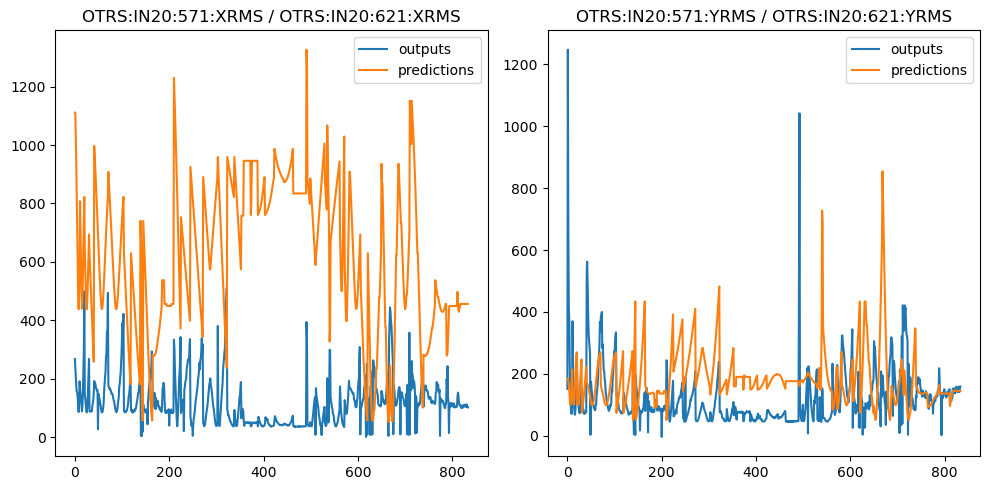

In [20]:
# plot example data and predictions
nrows, ncols = 1, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
for i, output_name in enumerate(lume_module.output_order):
    x_axis = torch.arange(y.shape[0])
    ax[i].plot(x_axis, y[:, i], "C0-", label="outputs")
    ax[i].plot(x_axis, predictions[:, i], "C1-", label="predictions")
    ax[i].legend()
    ax[i].set_title(output_name + " / " + output_df_complete.columns[i])
fig.tight_layout()

## Normalize Data to NN Units

In [21]:
# inputs
x_n = x
for input_transformer in lume_model.input_transformers:
    x_n = input_transformer(x_n)
# outputs
y_n = y
for output_transformer in lume_model.output_transformers[::-1]:
    y_n = output_transformer(y_n)

In [22]:
# calculate normalized predictions
with torch.no_grad():
    predictions_n = base_model(x_n)
predictions_n.shape

torch.Size([834, 5])

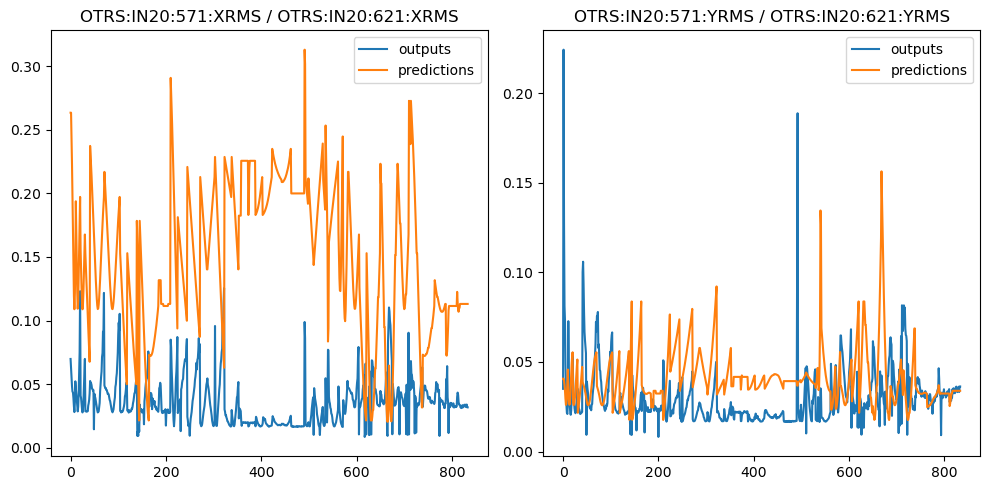

In [23]:
# plot example data and predictions
nrows, ncols = 1, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
for i, output_name in enumerate(lume_module.output_order):
    x_axis = torch.arange(y.shape[0])
    ax[i].plot(x_axis, y_n[:, i], "C0-", label="outputs")
    ax[i].plot(x_axis, predictions_n[:, i], "C1-", label="predictions")
    ax[i].legend()
    ax[i].set_title(output_name + " / " + output_df_complete.columns[i])
fig.tight_layout()

## Save Data to File

In [24]:
# unnormalized data
df_n = pd.concat([input_df_complete, output_df_complete[output_df_complete.columns[:2]]], axis=1)
df_n.to_csv(data_dir + "calibration_data.csv", index=False)

# normalized data
torch.save(x_n, data_dir + "normalized_calibration_inputs.pt")
torch.save(y_n, data_dir + "normalized_calibration_outputs.pt")